In [3]:
import pandas as pd
from pandas.tseries.offsets import QuarterEnd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ardl import ARDL
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import statsmodels.formula.api as smf
from statsmodels.tsa.ardl import ardl_select_order
from datetime import datetime
import re
import io
import os
pd.options.display.max_seq_items = 4000 ## This is only for cosmetics.

## Introduction

This is the notebook file to replicate our macroeconometrics approach. This notebook does not contain the `blackmarblepy` application. Source data is from `blackmarblepy` for nightlight, and [BPS](https://www.bps.go.id/id/statistics-table/2/NTQwIzI=/-seri-2010--4--laju-pertumbuhan--y-on-y--pdrb-atas-dasar-harga-konstan-menurut-pengeluaran--2010-100---persen-.html). If you happens to find any issues, you can find Tim via timothy.ginting@dewanekonomi.go.id

You will see the following sections in this notebook:

1. Real GDP and quarterly night light index (NTL) graph;
2. OLS and residuals;
3. ADF test and Johansen Cointegration test;
4. VECM graph;
5. VAR graph; and
6. ARDL graph.

We do those steps for both quarterly dataset and growth dataset.

## Quarterly Real GDP vs Quarterly NTL.

### Dataset

turn on the last line to see the dataframe.

In [4]:
## Data prep
### Creating data
ntl=pd.read_excel('data/ntl_monthly_avg_2012-2025.xlsx')
gdp=pd.read_excel('data/GDP_YoY_Quarterly_12_25.xlsx')

### Make time index
ntl.Date=pd.to_datetime(ntl['Date'])
ntl['qtr']=ntl['Date'].dt.quarter
ntl['year']=ntl['Date'].dt.year
### Averaging the radiance into quarterly, make it yoy quarterly growth
ntl=ntl.groupby(['year','qtr'])['NTL_Radiance'].mean().reset_index()
ntl['Date']=pd.date_range(start='2012-01-01', periods=len(ntl), freq='QE')
ntl=ntl[['Date','NTL_Radiance']]
ntl['g']=np.log(gdp['GDP'])
ntl['ntlg']=np.log(ntl['NTL_Radiance'])
#ntl['NTL_Radiancelag'] = ntl['NTL_Radiance'].shift(4)
#ntl['ntlg'] = ((ntl['NTL_Radiance'] - ntl['NTL_Radiancelag']) / ntl['NTL_Radiancelag']) * 100
### Creating dummy quarterly and dummy covid
ntl['q1']=np.where(ntl['Date'].dt.quarter==1,1,0)
ntl['q2']=np.where(ntl['Date'].dt.quarter==2,1,0)
ntl['q3']=np.where(ntl['Date'].dt.quarter==3,1,0)
ntl['q4']=np.where(ntl['Date'].dt.quarter==4,1,0)
ntl['covid']=np.where((ntl['Date'].dt.year>=2020) & (ntl['Date'].dt.year<=2022),1,0)
ntl['scar']=np.where((ntl['Date'].dt.year>=2020) ,1,0)
### Back to making time index
ntl=ntl.dropna().reset_index(drop=True)
ntl=ntl.set_index('Date')
ntl=ntl.asfreq('QE-DEC')
#ntlm=ntlm[['g','ntlg']]
ntlm = ntl.copy()


### Creating dummy quarterly and dummy covid

## OLS-ing
mod=sm.OLS(ntl['g'], sm.add_constant(ntl['ntlg'])).fit()
ntl['resid']=mod.resid
ntl['ols']=mod.predict()
#ntl

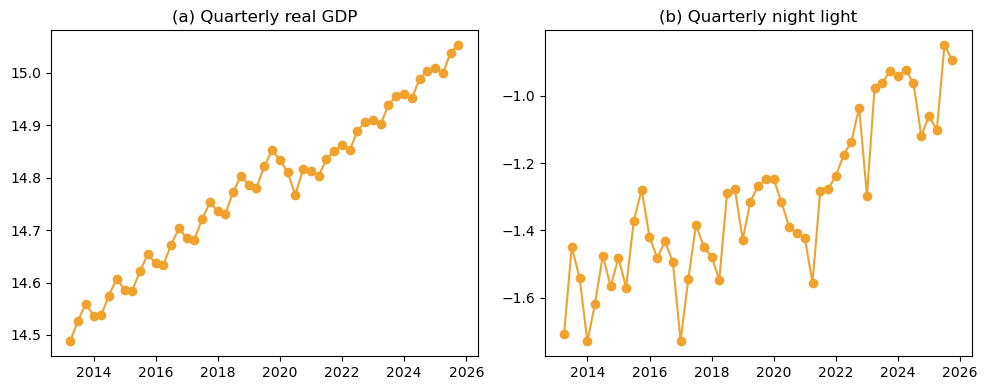

In [5]:
# Plotting GDP Growth and Night light growth side by side

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ntlm=ntl[4:]
ax1.plot(ntlm['g'],color='#f0a22e',marker='o', linestyle='-')
ax1.set_title('(a) Quarterly real GDP')

ax2.plot(ntlm['ntlg'], linestyle='-', color='#f0a22e',marker='o')
ax2.set_title('(b) Quarterly night light')

plt.tight_layout()
plt.savefig("fig/figQ.png") # Turn off to not save, or change file name to save in your preferred location
plt.show()

### OLS and residuals

                            OLS Regression Results                            
Dep. Variable:                      g   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     175.8
Date:                Wed, 04 Feb 2026   Prob (F-statistic):           1.83e-18
Time:                        21:46:49   Log-Likelihood:                 61.443
No. Observations:                  55   AIC:                            -118.9
Df Residuals:                      53   BIC:                            -114.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.4878      0.056    275.961      0.0

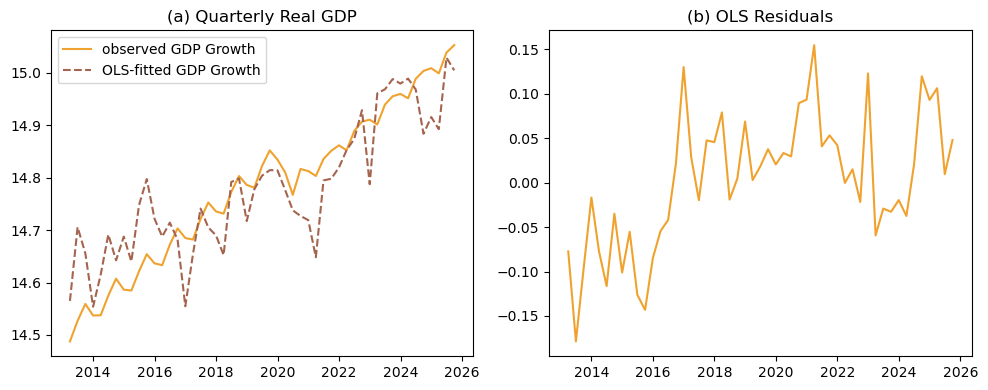

In [6]:
## OLS results and plotting residuals
ntl=ntlm
print(mod.summary())
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.plot(ntlm['g'],color='#f0a22e',linestyle="-",label="observed GDP Growth")
ax1.plot(ntlm['ols'],color='#a5644e',linestyle="--",label="OLS-fitted GDP Growth")
ax1.set_title('(a) Quarterly Real GDP')
ax1.legend()

ax2.plot(ntlm['resid'], linestyle='-', color='#f0a22e')
ax2.set_title('(b) OLS Residuals')

plt.tight_layout()
plt.savefig("fig/Qols.png") # Turn off to not save, or change file name to save in your preferred location
plt.show()

### ADF test of the series and residuals.

We don't first diff in this step cuz we do another ADF test on the growth dataset.

In [7]:
## ADF Test for g, ntlg and OLS residuals
def adf_test(series, name=""):
    """
    Perform ADF test and print results
    """
    result = adfuller(series.dropna(), autolag="BIC")
    print(f"ADF Test for {name}")
    print(f"  Test Statistic : {result[0]:.4f}")
    print(f"  p-value        : {result[1]:.4f}")
    print(f"  #Lags Used     : {result[2]}")
    print(f"  #Observations  : {result[3]}")
    for key, value in result[4].items():
        print(f"   Critical Value {key} : {value:.4f}")
    if result[1] <= 0.05:
        print(f"  ==> {name} is stationary\n (reject H0 of unit root)\n")
    else:
        print(f"  ==> {name} is non-stationary\n (fail to reject H0)\n")

# Run ADF tests for both series
adf_test(ntlm["g"], "GDP YoY Growth")
adf_test(ntlm["ntlg"], "NTL YoY Growth")
adf_test(ntlm["resid"], "OLS Residuals")

ADF Test for GDP YoY Growth
  Test Statistic : -0.3748
  p-value        : 0.9142
  #Lags Used     : 4
  #Observations  : 46
   Critical Value 1% : -3.5813
   Critical Value 5% : -2.9268
   Critical Value 10% : -2.6015
  ==> GDP YoY Growth is non-stationary
 (fail to reject H0)

ADF Test for NTL YoY Growth
  Test Statistic : -2.0542
  p-value        : 0.2633
  #Lags Used     : 0
  #Observations  : 50
   Critical Value 1% : -3.5685
   Critical Value 5% : -2.9214
   Critical Value 10% : -2.5987
  ==> NTL YoY Growth is non-stationary
 (fail to reject H0)

ADF Test for OLS Residuals
  Test Statistic : -3.4638
  p-value        : 0.0090
  #Lags Used     : 0
  #Observations  : 50
   Critical Value 1% : -3.5685
   Critical Value 5% : -2.9214
   Critical Value 10% : -2.5987
  ==> OLS Residuals is stationary
 (reject H0 of unit root)



### Johansen cointegration test

In [8]:
# Select optimal lag order
ntlm=ntl[['g','ntlg']]
lag_order = select_order(ntlm, maxlags=12, deterministic="ci")
print(lag_order.summary())

# Select cointegration rank
coint_rank = select_coint_rank(ntlm, det_order=1, k_ar_diff=lag_order.bic)
print(coint_rank.summary())

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.99     -11.64*   6.241e-06      -11.86
1       -11.95      -11.43   6.505e-06      -11.76
2       -12.10      -11.41   5.658e-06      -11.85
3      -12.48*      -11.62  3.903e-06*     -12.17*
4       -12.41      -11.37   4.275e-06      -12.04
5       -12.24      -11.03   5.200e-06      -11.81
6       -12.14      -10.76   5.954e-06      -11.65
7       -12.18      -10.63   6.056e-06      -11.63
8       -12.25      -10.53   6.039e-06      -11.64
9       -12.46      -10.56   5.406e-06      -11.78
10      -12.43      -10.36   6.285e-06      -11.69
11      -12.31      -10.07   8.278e-06      -11.52
12      -12.44      -10.03   9.011e-06      -11.59
--------------------------------------------------
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------

### VECM with quarterly dataset

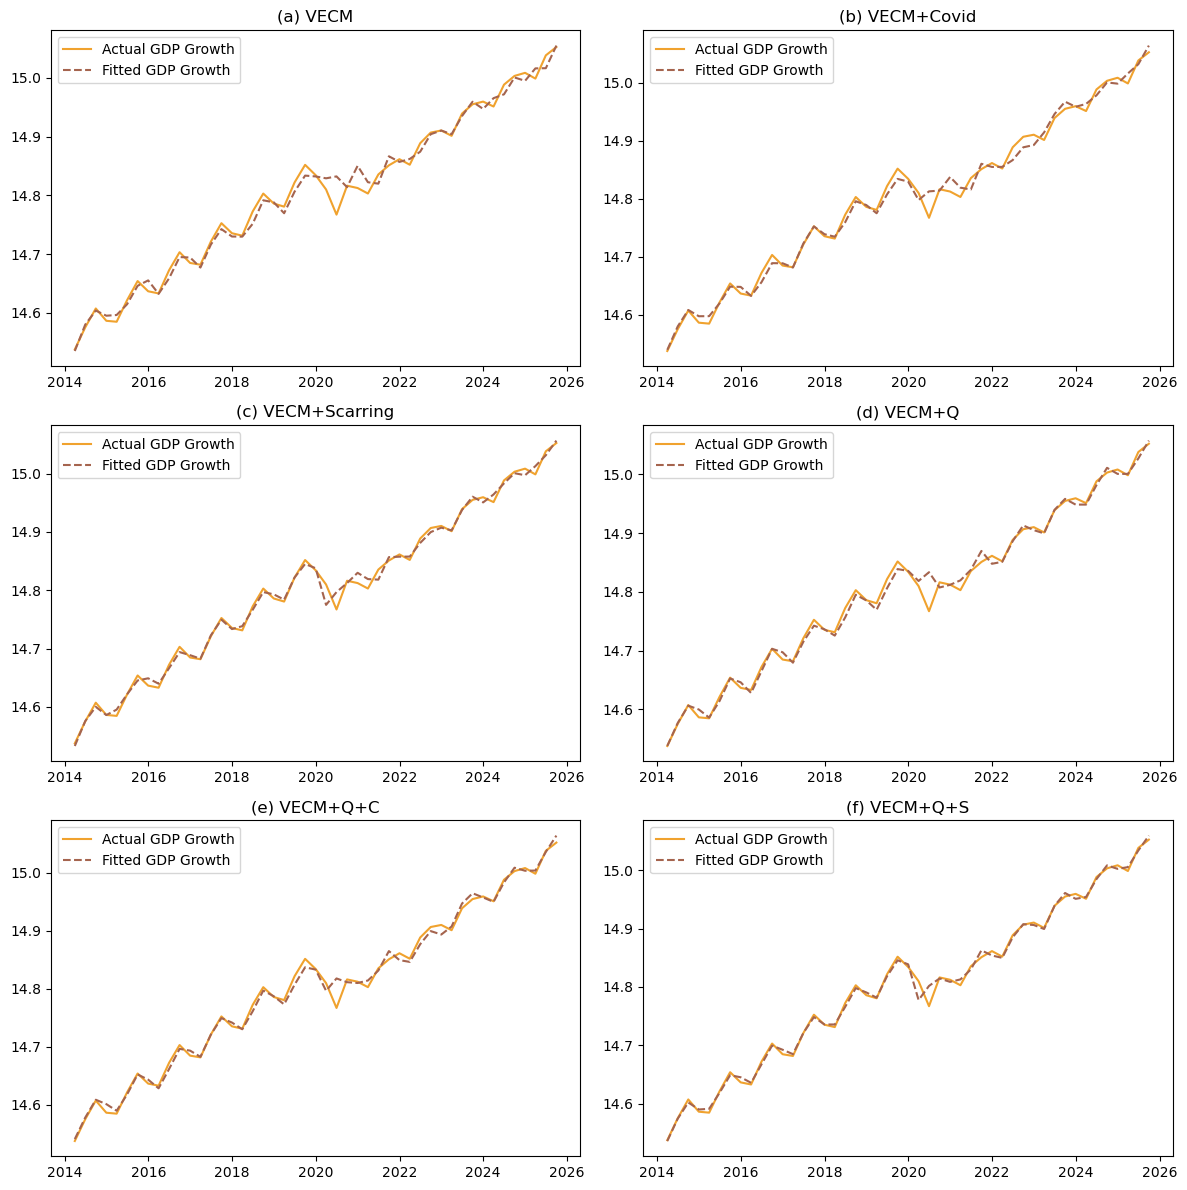

In [10]:
en=ntl[['g','ntlg']]
exc=ntl[['covid']]
exs=ntl[['scar']]
exq=ntl[['q1','q2','q3']]
exqc=ntl[['q1','q2','q3','covid']]
exqs=ntl[['q1','q2','q3','scar']]

lag=lag_order.aic

ve = VECM(en,k_ar_diff=lag, coint_rank=2, deterministic="cili").fit()
vec = VECM(en,k_ar_diff=lag, coint_rank=2, exog=exc,deterministic="cili").fit()
ves = VECM(en,k_ar_diff=lag, coint_rank=2, exog=exs,deterministic="cili").fit()
veq = VECM(en,k_ar_diff=lag, coint_rank=2, exog=exq,deterministic="cili").fit()
veqc = VECM(en,k_ar_diff=lag, coint_rank=2, exog=exqc,deterministic="cili").fit()
veqs = VECM(en,k_ar_diff=lag, coint_rank=2, exog=exqs,deterministic="cili").fit()

models = {'fve': ve, 'fvec': vec,'fves': ves, 'fveq': veq,'fveqc': veqc, 'fveqs': veqs}
results = {}

for name, model in models.items():
    fitted = pd.DataFrame(model.fittedvalues, columns=en.columns)
    fitted.index = en.index[-len(fitted):]  # Align to last N dates
    merged = pd.merge(en, fitted, left_index=True, right_index=True, suffixes=('', '_fitted'))
    results[name] = merged


fig, ax = plt.subplots(3,2,figsize=(12, 12))

ax[0,0].plot(results['fve']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[0,0].plot(results['fve']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[0,0].set_title('(a) VECM')
ax[0,0].legend()

ax[0,1].plot(results['fvec']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[0,1].plot(results['fvec']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[0,1].set_title('(b) VECM+Covid')
ax[0,1].legend()

ax[1,0].plot(results['fves']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[1,0].plot(results['fves']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[1,0].set_title('(c) VECM+Scarring')
ax[1,0].legend()

ax[1,1].plot(results['fveq']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[1,1].plot(results['fveq']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[1,1].set_title('(d) VECM+Q')
ax[1,1].legend()

ax[2,0].plot(results['fveqc']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[2,0].plot(results['fveqc']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[2,0].set_title('(e) VECM+Q+C')
ax[2,0].legend()

ax[2,1].plot(results['fveqs']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[2,1].plot(results['fveqs']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[2,1].set_title('(f) VECM+Q+S')
ax[2,1].legend()
plt.tight_layout()
plt.savefig("fig/VECMQ.png")
plt.show()

## ARDL with quarterly dataset

c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q1.
  return _format_order(self.data.orig_exog, order, self._causal)
c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q1.
  return _format_order(self.data.orig_exog, order, self._causal)
c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q2.
  return _format_order(self.data.orig_exog, order, self._causal)


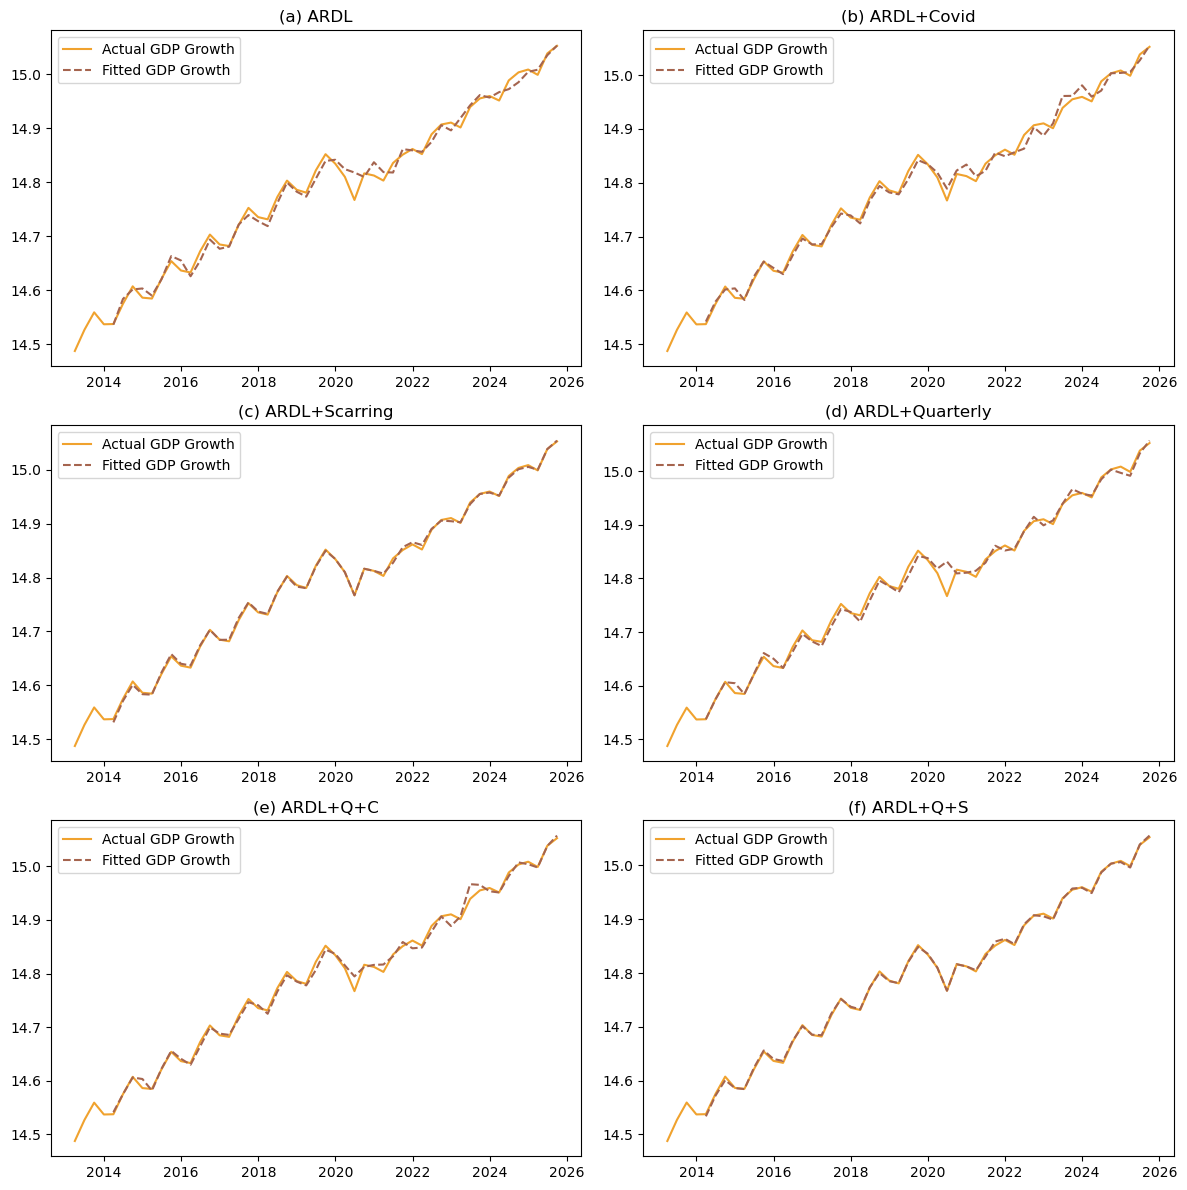

In [11]:
en=ntl[['g']]
ex=ntl[['ntlg']]
exc=ntl[['ntlg','covid']]
exs=ntl[['ntlg','scar']]
exq=ntl[['ntlg','q1','q2','q3']]
exqc=ntl[['ntlg','q1','q2','q3','covid']]
exqs=ntl[['ntlg','q1','q2','q3','scar']]

lags = ardl_select_order(endog=en, exog=ex, maxlag=4,maxorder=4, ic='aic',seasonal=False)
ve = ARDL(endog=en,lags=lags.ar_lags,exog=ex,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exc, maxlag=4,maxorder=4, ic='aic',seasonal=False)
vec= ARDL(endog=en,lags=lags.ar_lags,exog=exc,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exs, maxlag=4,maxorder=4, ic='aic',seasonal=False)
ves= ARDL(endog=en,lags=lags.ar_lags,exog=exs,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exq, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veq= ARDL(endog=en,lags=lags.ar_lags,exog=exq,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exqc, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veqc= ARDL(endog=en,lags=lags.ar_lags,exog=exqc,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exqs, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veqs= ARDL(endog=en,lags=lags.ar_lags,exog=exqs,order=lags.dl_lags,trend='ct').fit() # This looks too good to be true

models = {'fve': ve, 'fvec': vec,'fves': ves, 'fveq': veq,'fveqc': veqc, 'fveqs': veqs}
results = {}

for name, model in models.items():
    fitted = pd.DataFrame(model.fittedvalues, columns=['g_fitted'])
    merged = pd.merge(en, fitted, left_index=True, right_index=True, how='left')
    results[name] = merged


fig, ax = plt.subplots(3,2,figsize=(12, 12))

ax[0,0].plot(results['fve']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[0,0].plot(results['fve']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[0,0].set_title('(a) ARDL')
ax[0,0].legend()

ax[0,1].plot(results['fvec']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[0,1].plot(results['fvec']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[0,1].set_title('(b) ARDL+Covid')
ax[0,1].legend()

ax[1,0].plot(results['fves']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[1,0].plot(results['fves']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[1,0].set_title('(c) ARDL+Scarring')
ax[1,0].legend()

ax[1,1].plot(results['fveq']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[1,1].plot(results['fveq']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[1,1].set_title('(d) ARDL+Quarterly')
ax[1,1].legend()

ax[2,0].plot(results['fveqc']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[2,0].plot(results['fveqc']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[2,0].set_title('(e) ARDL+Q+C')
ax[2,0].legend()

ax[2,1].plot(results['fveqs']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[2,1].plot(results['fveqs']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[2,1].set_title('(f) ARDL+Q+S')
ax[2,1].legend()
plt.tight_layout()
plt.savefig("fig/ARDLQ.png") # Turn off to not save, or change file name to save in your preferred location
plt.show()

## Growth Regression

### The GDP and night light growth dataset
Turn on the last line of the first codeblock to see the dataframe

In [13]:
## Data prep
### Creating data
ntl=pd.read_excel('data/ntl_monthly_avg_2012-2025.xlsx')
gdp=pd.read_excel('data/GDP_YoY_Quarterly_12_25.xlsx')

### Make time index
ntl.Date=pd.to_datetime(ntl['Date'])
ntl['qtr']=ntl['Date'].dt.quarter
ntl['year']=ntl['Date'].dt.year
### Averaging the radiance into quarterly, make it yoy quarterly growth
ntl=ntl.groupby(['year','qtr'])['NTL_Radiance'].mean().reset_index()
ntl['Date']=pd.date_range(start='2012-01-01', periods=len(ntl), freq='QE')
ntl=ntl[['Date','NTL_Radiance']]
ntl['g']=(gdp['Real GDP YoY Growth Indonesia'])
ntl['ntlg']=(ntl['NTL_Radiance'])
ntl['NTL_Radiancelag'] = ntl['NTL_Radiance'].shift(4)
ntl['ntlg'] = ((ntl['NTL_Radiance'] - ntl['NTL_Radiancelag']) / ntl['NTL_Radiancelag']) * 100
### Creating dummy quarterly and dummy covid
ntl['q1']=np.where(ntl['Date'].dt.quarter==1,1,0)
ntl['q2']=np.where(ntl['Date'].dt.quarter==2,1,0)
ntl['q3']=np.where(ntl['Date'].dt.quarter==3,1,0)
ntl['q4']=np.where(ntl['Date'].dt.quarter==4,1,0)
ntl['covid']=np.where((ntl['Date'].dt.year>=2020) & (ntl['Date'].dt.year<=2022),1,0)
ntl['scar']=np.where((ntl['Date'].dt.year>=2020) ,1,0)
### Back to making time index
ntl=ntl.dropna().reset_index(drop=True)
ntl=ntl.set_index('Date')
ntl=ntl.asfreq('QE-DEC')
#ntlm=ntlm[['g','ntlg']]

### Creating dummy quarterly and dummy covid

## OLS-ing
mod=sm.OLS(ntl['g'], sm.add_constant(ntl['ntlg'])).fit()
ntl['resid']=mod.resid
ntl['ols']=mod.predict()
#ntl

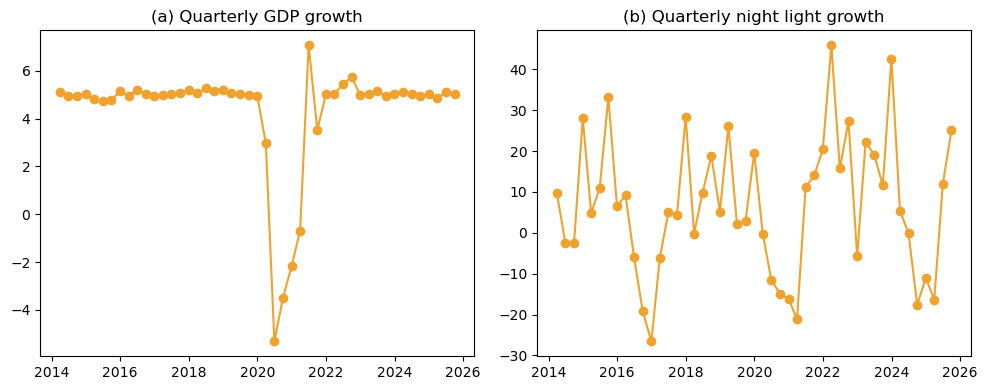

In [14]:
# Plotting GDP Growth and Night light growth side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ntlm=ntl[4:]
ax1.plot(ntlm['g'],color='#f0a22e',marker='o', linestyle='-')
ax1.set_title('(a) Quarterly GDP growth')

ax2.plot(ntlm['ntlg'], linestyle='-', color='#f0a22e',marker='o')
ax2.set_title('(b) Quarterly night light growth')

plt.tight_layout()
plt.savefig("fig/fig.png")
plt.show()

### OLS Regression

                            OLS Regression Results                            
Dep. Variable:                      g   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     8.164
Date:                Wed, 04 Feb 2026   Prob (F-statistic):            0.00625
Time:                        21:53:07   Log-Likelihood:                -109.92
No. Observations:                  51   AIC:                             223.8
Df Residuals:                      49   BIC:                             227.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0651      0.326     12.471      0.0

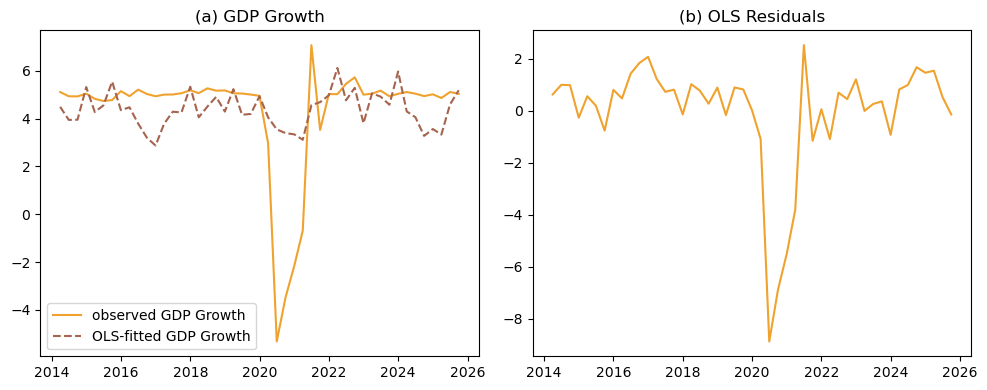

In [15]:
## OLS results and plotting residuals
ntl=ntlm
print(mod.summary())
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.plot(ntlm['g'],color='#f0a22e',linestyle="-",label="observed GDP Growth")
ax1.plot(ntlm['ols'],color='#a5644e',linestyle="--",label="OLS-fitted GDP Growth")
ax1.set_title('(a) GDP Growth')
ax1.legend()

ax2.plot(ntlm['resid'], linestyle='-', color='#f0a22e')
ax2.set_title('(b) OLS Residuals')

plt.tight_layout()
plt.savefig("fig/ols.png") # Turn off to not save, or change file name to save in your preferred location
plt.show()

### ADF Test

In [16]:
## ADF Test for g, ntlg and OLS residuals
def adf_test(series, name=""):
    """
    Perform ADF test and print results
    """
    result = adfuller(series.dropna(), autolag="BIC")
    print(f"ADF Test for {name}")
    print(f"  Test Statistic : {result[0]:.4f}")
    print(f"  p-value        : {result[1]:.4f}")
    print(f"  #Lags Used     : {result[2]}")
    print(f"  #Observations  : {result[3]}")
    for key, value in result[4].items():
        print(f"   Critical Value {key} : {value:.4f}")
    if result[1] <= 0.05:
        print(f"  ==> {name} is stationary\n (reject H0 of unit root)\n")
    else:
        print(f"  ==> {name} is non-stationary\n (fail to reject H0)\n")

# Run ADF tests for both series
adf_test(ntlm["g"], "GDP YoY Growth")
adf_test(ntlm["ntlg"], "NTL YoY Growth")
adf_test(ntlm["resid"], "OLS Residuals")

ADF Test for GDP YoY Growth
  Test Statistic : -2.8369
  p-value        : 0.0532
  #Lags Used     : 0
  #Observations  : 46
   Critical Value 1% : -3.5813
   Critical Value 5% : -2.9268
   Critical Value 10% : -2.6015
  ==> GDP YoY Growth is non-stationary
 (fail to reject H0)

ADF Test for NTL YoY Growth
  Test Statistic : -4.7696
  p-value        : 0.0001
  #Lags Used     : 3
  #Observations  : 43
   Critical Value 1% : -3.5925
   Critical Value 5% : -2.9315
   Critical Value 10% : -2.6041
  ==> NTL YoY Growth is stationary
 (reject H0 of unit root)

ADF Test for OLS Residuals
  Test Statistic : -3.1047
  p-value        : 0.0262
  #Lags Used     : 0
  #Observations  : 46
   Critical Value 1% : -3.5813
   Critical Value 5% : -2.9268
   Critical Value 10% : -2.6015
  ==> OLS Residuals is stationary
 (reject H0 of unit root)



### Johansen Cointegration test

In [17]:
# Select optimal lag order
ntlm=ntl[['g','ntlg']]
lag_order = select_order(ntlm.asfreq('QE-DEC'), maxlags=12, deterministic="ci")
print(lag_order.summary())

# Select cointegration rank
coint_rank = select_coint_rank(ntlm.asfreq('QE-DEC'), det_order=0, k_ar_diff=lag_order.bic)
print(coint_rank.summary())

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        7.068      7.427*       1176.       7.190
1        7.264       7.803       1439.       7.448
2        7.393       8.111       1654.       7.638
3        7.144       8.042       1313.       7.451
4        7.097       8.174       1287.       7.464
5        7.157       8.414       1424.       7.586
6        7.319       8.756       1772.       7.809
7        7.127       8.743       1582.       7.678
8        7.296       9.092       2087.       7.909
9        6.952       8.927       1711.       7.626
10       6.719       8.874       1655.       7.454
11       6.434       8.769       1645.       7.231
12      5.558*       8.072      1028.*      6.416*
--------------------------------------------------
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------

### VECM with growth 

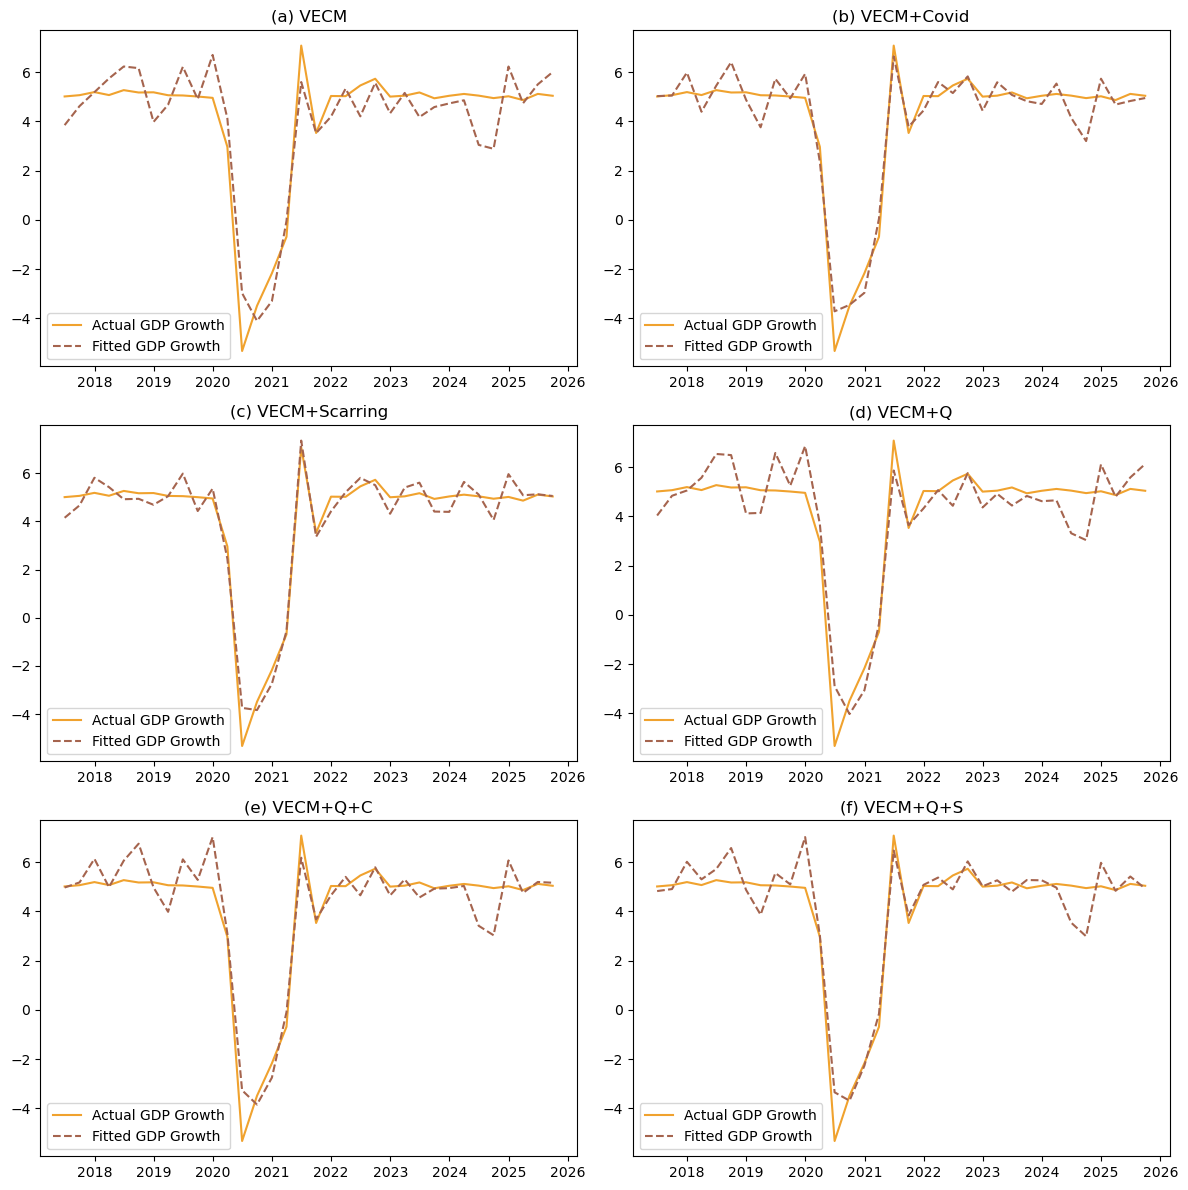

In [19]:
en=ntl[['g','ntlg']]
exc=ntl[['covid']]
exs=ntl[['scar']]
exq=ntl[['q1','q2','q3']]
exqc=ntl[['q1','q2','q3','covid']]
exqs=ntl[['q1','q2','q3','scar']]

lag=lag_order.aic

ve = VECM(en,k_ar_diff=lag, coint_rank=1, deterministic="ci").fit()
vec = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exc,deterministic="ci").fit()
ves = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exs,deterministic="ci").fit()
veq = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exq,deterministic="ci").fit()
veqc = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exqc,deterministic="ci").fit()
veqs = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exqs,deterministic="ci").fit()

models = {'fve': ve, 'fvec': vec,'fves': ves, 'fveq': veq,'fveqc': veqc, 'fveqs': veqs}
results = {}

for name, model in models.items():
    fitted = pd.DataFrame(model.fittedvalues, columns=en.columns)
    fitted.index = en.index[-len(fitted):]  # Align to last N dates
    merged = pd.merge(en, fitted, left_index=True, right_index=True, suffixes=('', '_fitted'))
    results[name] = merged


fig, ax = plt.subplots(3,2,figsize=(12, 12))

ax[0,0].plot(results['fve']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[0,0].plot(results['fve']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[0,0].set_title('(a) VECM')
ax[0,0].legend()

ax[0,1].plot(results['fvec']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[0,1].plot(results['fvec']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[0,1].set_title('(b) VECM+Covid')
ax[0,1].legend()

ax[1,0].plot(results['fves']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[1,0].plot(results['fves']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[1,0].set_title('(c) VECM+Scarring')
ax[1,0].legend()

ax[1,1].plot(results['fveq']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[1,1].plot(results['fveq']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[1,1].set_title('(d) VECM+Q')
ax[1,1].legend()

ax[2,0].plot(results['fveqc']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[2,0].plot(results['fveqc']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[2,0].set_title('(e) VECM+Q+C')
ax[2,0].legend()

ax[2,1].plot(results['fveqs']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[2,1].plot(results['fveqs']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[2,1].set_title('(f) VECM+Q+S')
ax[2,1].legend()
plt.tight_layout()
plt.savefig("fig/VECM.png")
plt.show()

### VAR with growth

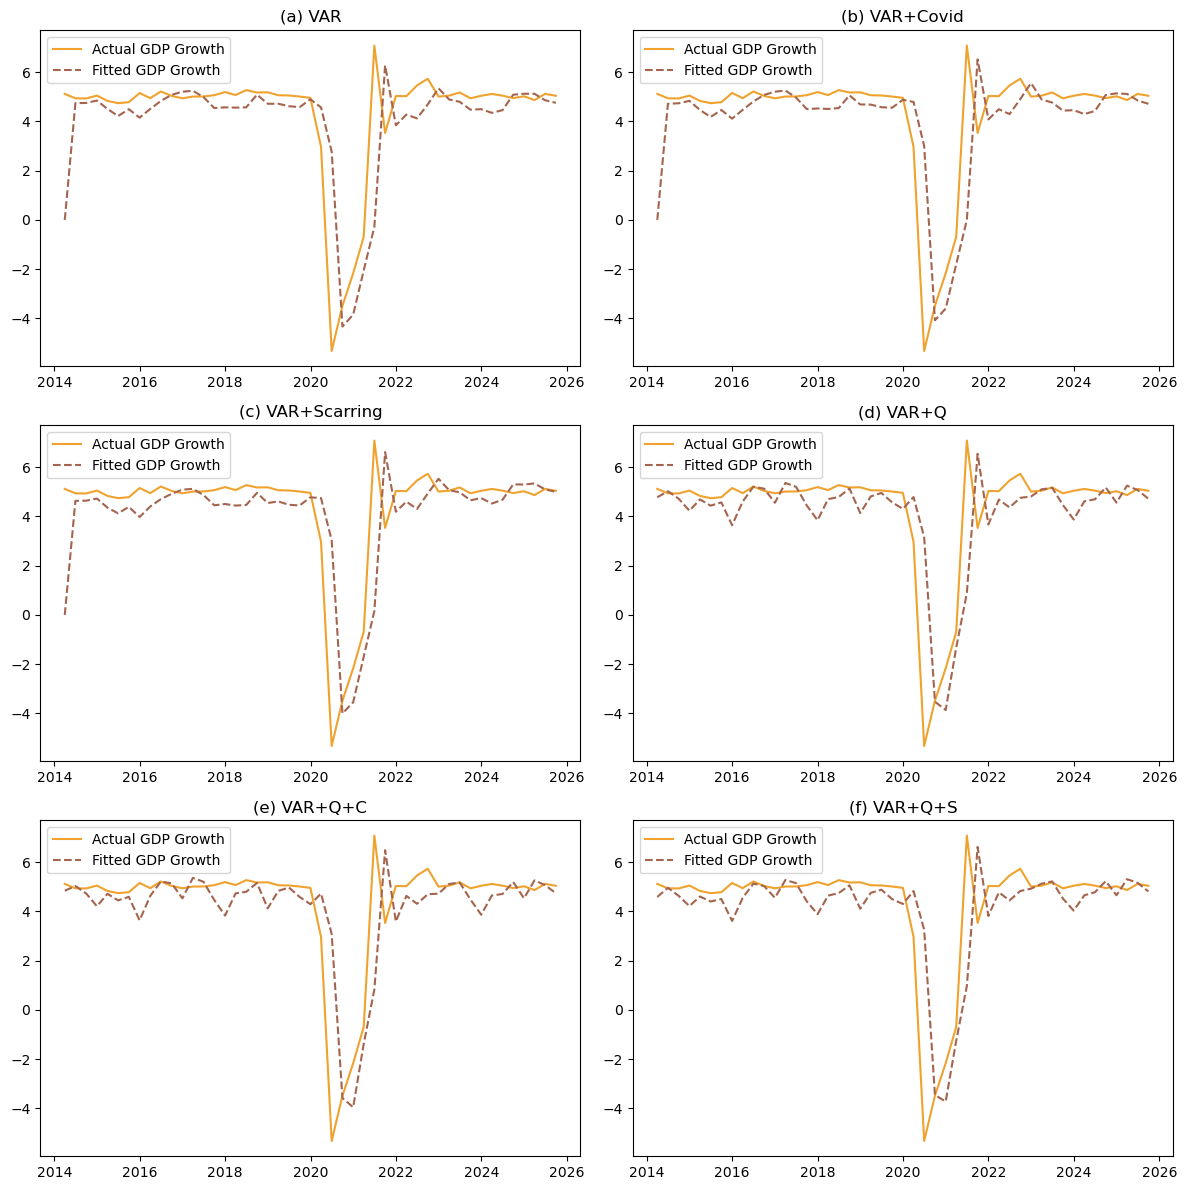

In [21]:

en=ntl[['g','ntlg']]
exc=ntl[['covid']]
exs=ntl[['scar']]
exq=ntl[['q1','q2','q3']]
exqc=ntl[['q1','q2','q3','covid']]
exqs=ntl[['q1','q2','q3','scar']]

#lag=lag_order.aic

ve = sm.tsa.VARMAX(en, order=(4,0), trend='n').fit(maxiter=1000, disp=False)
vec = sm.tsa.VARMAX(en, order=(4,0), trend='n',exog=exc).fit(maxiter=1000, disp=False)
ves = sm.tsa.VARMAX(en, order=(4,0), trend='n',exog=exs).fit(maxiter=1000, disp=False)
veq = sm.tsa.VARMAX(en, order=(4,0), trend='n',exog=exq).fit(maxiter=1000, disp=False)
veqc = sm.tsa.VARMAX(en, order=(4,0), trend='n',exog=exqc).fit(maxiter=1000, disp=False)
veqs = sm.tsa.VARMAX(en, order=(4,0), trend='n',exog=exqs).fit(maxiter=1000, disp=False)


models = {'fve': ve, 'fvec': vec,'fves': ves, 'fveq': veq,'fveqc': veqc, 'fveqs': veqs}
results = {}

for name, model in models.items():
    fitted = pd.DataFrame(model.fittedvalues, columns=en.columns)
    fitted.index = en.index[-len(fitted):]  # Align to last N dates
    merged = pd.merge(en, fitted, left_index=True, right_index=True, suffixes=('', '_fitted'))
    results[name] = merged

fig, ax = plt.subplots(3,2,figsize=(12, 12))

ax[0,0].plot(results['fve']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[0,0].plot(results['fve']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[0,0].set_title('(a) VAR')
ax[0,0].legend()

ax[0,1].plot(results['fvec']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[0,1].plot(results['fvec']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[0,1].set_title('(b) VAR+Covid')
ax[0,1].legend()

ax[1,0].plot(results['fves']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[1,0].plot(results['fves']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[1,0].set_title('(c) VAR+Scarring')
ax[1,0].legend()

ax[1,1].plot(results['fveq']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[1,1].plot(results['fveq']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[1,1].set_title('(d) VAR+Q')
ax[1,1].legend()

ax[2,0].plot(results['fveqc']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[2,0].plot(results['fveqc']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[2,0].set_title('(e) VAR+Q+C')
ax[2,0].legend()

ax[2,1].plot(results['fveqs']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[2,1].plot(results['fveqs']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[2,1].set_title('(f) VAR+Q+S')
ax[2,1].legend()
plt.tight_layout()
plt.savefig("fig/VAR.png")
plt.show()

### ARDL with growth

c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q2, q3, q1.
  return _format_order(self.data.orig_exog, order, self._causal)
c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q2, q1, ntlg, q3.
  return _format_order(self.data.orig_exog, order, self._causal)
c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ntlg, q3.
  return _format_order(self.data.orig_exog, order, self._causal)


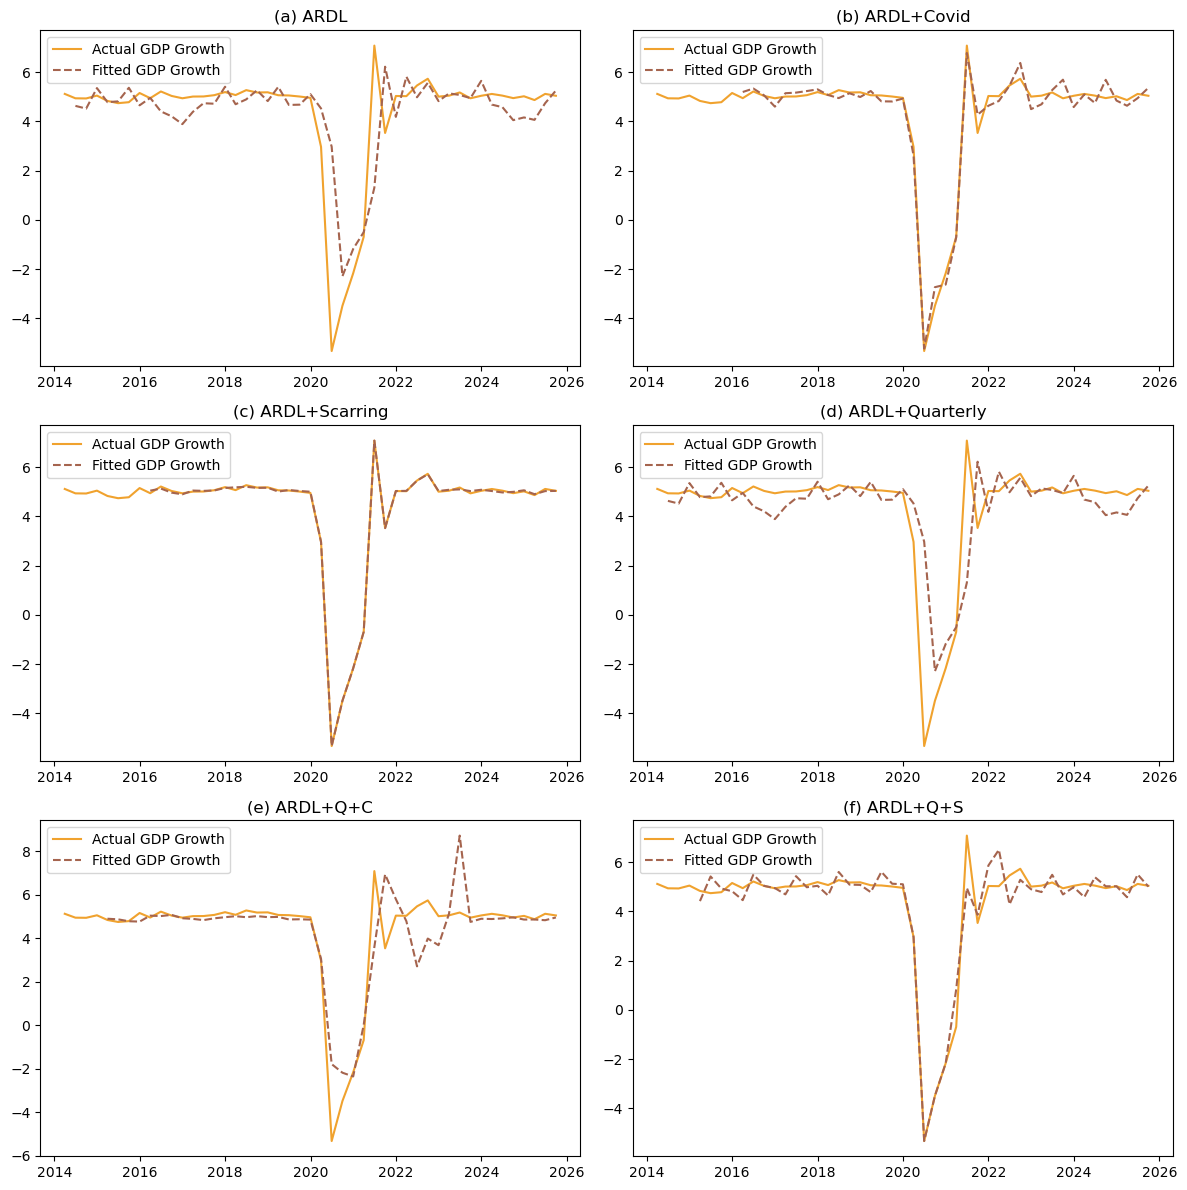

In [22]:
en=ntl[['g']]
ex=ntl[['ntlg']]
exc=ntl[['ntlg','covid']]
exs=ntl[['ntlg','scar']]
exq=ntl[['ntlg','q1','q2','q3']]
exqc=ntl[['ntlg','q1','q2','q3','covid']]
exqs=ntl[['ntlg','q1','q2','q3','scar']]

lags = ardl_select_order(endog=en, exog=ex, maxlag=8,maxorder=8, ic='aic',seasonal=False)
ve = ARDL(endog=en,lags=lags.ar_lags,exog=ex,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exc, maxlag=8,maxorder=8, ic='aic',seasonal=False)
vec= ARDL(endog=en,lags=lags.ar_lags,exog=exc,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exs, maxlag=8,maxorder=8, ic='aic',seasonal=False)
ves= ARDL(endog=en,lags=lags.ar_lags,exog=exs,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exq, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veq= ARDL(endog=en,lags=lags.ar_lags,exog=exq,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exqc, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veqc= ARDL(endog=en,lags=lags.ar_lags,exog=exqc,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exqs, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veqs= ARDL(endog=en,lags=lags.ar_lags,exog=exqs,order=lags.dl_lags,trend='ct').fit()

models = {'fve': ve, 'fvec': vec,'fves': ves}
results = {}

for name, model in models.items():
    fitted = pd.DataFrame(model.predict(), columns=en.columns)
    fitted.index = en.index[-len(fitted):]  # Align to last N dates
    merged = pd.merge(en, fitted, left_index=True, right_index=True, suffixes=('', '_fitted'))
    results[name] = merged

models = {'fveq': veq,'fveqc': veqc, 'fveqs': veqs}
result = {}

for name, model in models.items():
    fitted = pd.DataFrame(model.predict(), columns=en.columns)
    fitted.index = en.index[-len(fitted):]  # Align to last N dates
    merged = pd.merge(en, fitted, left_index=True, right_index=True, suffixes=('', '_fitted'))
    result[name] = merged



fig, ax = plt.subplots(3,2,figsize=(12, 12))

ax[0,0].plot(results['fve']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[0,0].plot(results['fve']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[0,0].set_title('(a) ARDL')
ax[0,0].legend()

ax[0,1].plot(results['fvec']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[0,1].plot(results['fvec']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[0,1].set_title('(b) ARDL+Covid')
ax[0,1].legend()

ax[1,0].plot(results['fves']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[1,0].plot(results['fves']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[1,0].set_title('(c) ARDL+Scarring')
ax[1,0].legend()

ax[1,1].plot(result['fveq']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[1,1].plot(result['fveq']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[1,1].set_title('(d) ARDL+Quarterly')
ax[1,1].legend()

ax[2,0].plot(result['fveqc']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[2,0].plot(result['fveqc']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[2,0].set_title('(e) ARDL+Q+C')
ax[2,0].legend()

ax[2,1].plot(result['fveqs']['g'],color='#f0a22e',linestyle='-',label="Actual GDP Growth")
ax[2,1].plot(result['fveqs']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted GDP Growth")
ax[2,1].set_title('(f) ARDL+Q+S')
ax[2,1].legend()
plt.tight_layout()
plt.savefig("fig/ARDL.png")
plt.show()

In [ ]:
# Model Functions

def run_vecm(en_train, exog_train, rank=1, det="ci", maxlags=8):
    """VECM with exogenous terms and valid det_type ('ci' or 'co')."""
    if det not in ["ci", "co"]:
        raise ValueError("det_type must be 'ci' or 'co' for VECM.")
    try:
        sel = select_order(en_train, maxlags=maxlags, deterministic=det)
        lag = sel.aic if (sel.aic is not None and sel.aic >= 1) else 1
    except Exception as e:
        print(f"select_order failed ({e}); fallback lag=1")
        lag = 1
    print(f"VECM | lag={lag}, rank={rank}, det={det}")
    model = VECM(en_train, k_ar_diff=lag, coint_rank=rank,
                 deterministic=det, exog=exog_train).fit()
    fitted = pd.DataFrame(model.fittedvalues, columns=en_train.columns,
                          index=en_train.index[-len(model.fittedvalues):])
    return model, fitted

def run_var(en_train, exog_train=None, maxlags=8):
    df = en_train.copy()
    if exog_train is not None:
        df = pd.concat([df, exog_train], axis=1)
    var_model = VAR(df)
    sel = var_model.select_order(maxlags=maxlags)
    p = max(sel.aic, 1) if sel.aic else 1
    print(f"VAR | lag={p}")
    res = var_model.fit(p)
    fitted = res.fittedvalues
    return res, fitted, p

def run_bvar_ridge(en_train, exog_train=None, p=2, lam=0.1):
    Y, X = [], []
    base = en_train.copy()
    if exog_train is not None:
        base = pd.concat([base, exog_train], axis=1)
    for t in range(p, len(base)):
        Y.append(base.values[t, :2])  # first 2 columns (g, ntlg)
        X.append(base.values[t-p:t].flatten())
    Y, X = np.array(Y), np.array(X)
    coefs = []
    for j in range(Y.shape[1]):
        ridge = Ridge(alpha=lam, fit_intercept=True)
        ridge.fit(X, Y[:, j])
        coefs.append(ridge)
    fitted_vals = np.array([r.predict(X) for r in coefs]).T
    fitted = pd.DataFrame(fitted_vals, index=base.index[p:], columns=['g','ntlg'])
    return coefs, fitted, p

def run_ardl(en_ardl, ex_ardl, maxlags=8):
    try:
        lag_sel = ardl_select_order(endog=en_ardl, exog=ex_ardl,
                                    maxlag=maxlags, maxorder=maxlags,
                                    ic="aic", seasonal=False)
        print(f"ARDL | AR lags={lag_sel.ar_lags}, exog lags={lag_sel.dl_lags}")
        model = ARDL(endog=en_ardl, lags=lag_sel.ar_lags,
                     exog=ex_ardl, order=lag_sel.dl_lags, trend="ct").fit()
    except Exception as e:
        print(f"ARDL selection failed ({e}); fallback (1,0)")
        model = ARDL(endog=en_ardl, lags=1, exog=ex_ardl, order=0, trend="ct").fit()
    fitted = model.fittedvalues.to_frame(name="g")
    return model, fitted

In [ ]:
def parse_ardl_summary(model_res):
    """Cleanly extract ARDL coefficients as a proper DataFrame."""
    try:
        summary_table = model_res.summary().tables[1]
        df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]
        df.reset_index(inplace=True)
        df.rename(columns={"index": "variable"}, inplace=True)
        return df
    except Exception:
        if hasattr(model_res, "params"):
            return pd.DataFrame({
                "variable": model_res.params.index,
                "coef": model_res.params.values,
                "std_err": getattr(model_res, "bse", np.nan),
                "z": getattr(model_res, "tvalues", np.nan),
                "P>|z|": getattr(model_res, "pvalues", np.nan)
            })
        else:
            return pd.DataFrame({"info": ["Could not parse ARDL coefficients."]})


def parse_text_summary(summary_text, start_pattern=None, end_pattern=None):
    """Generic parser for fixed-width text tables in statsmodels summaries."""
    lines = summary_text.splitlines()
    start, end = None, None
    if start_pattern:
        for i, line in enumerate(lines):
            if re.search(start_pattern, line):
                start = i + 2
            elif end_pattern and start is not None and re.search(end_pattern, line):
                end = i - 1
                break
    if start is None:
        start, end = 0, len(lines)
    block_lines = lines[start:end]
    data_lines = [ln for ln in block_lines if re.match(r"^[A-Za-zL0-9]", ln.strip())]
    if not data_lines:
        return None
    table_str = "\n".join(data_lines)
    df = pd.read_fwf(
        io.StringIO(table_str),
        names=["variable", "coef", "std_err", "z", "P>|z|", "CI_low", "CI_high"],
        infer_nrows=100
    )
    for col in ["coef", "std_err", "z", "P>|z|", "CI_low", "CI_high"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df.dropna(subset=["coef"], how="all")


def parse_var_summary_tables(model_res):
    """Extract both merged and detailed coefficient tables from VAR summary."""
    summary_text = str(model_res.summary())
    lines = summary_text.splitlines()
    results = []
    eq_name = None
    capture = False
    block_lines = []

    for line in lines:
        match_eq = re.match(r"Results for equation (.+)", line)
        if match_eq:
            if eq_name and block_lines:
                results.append((eq_name, "\n".join(block_lines)))
                block_lines = []
            eq_name = match_eq.group(1).strip()
            capture = True
            continue
        if capture and re.match(r"Correlation matrix", line):
            if eq_name and block_lines:
                results.append((eq_name, "\n".join(block_lines)))
            break
        elif capture and re.match(r"^[A-Za-zL0-9]", line.strip()):
            block_lines.append(line.strip())

    all_tables = []
    for eq_name, block in results:
        df = pd.read_fwf(
            io.StringIO(block),
            names=["variable", "coef", "std_err", "t_stat", "p_value"],
            infer_nrows=100
        )
        for c in ["coef", "std_err", "t_stat", "p_value"]:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        df["equation"] = eq_name
        all_tables.append(df)

    if not all_tables:
        return (pd.DataFrame({"info": ["No coefficients parsed from VAR summary."]}), None)

    # Compact merged table
    merged = None
    for df in all_tables:
        eq_name = df["equation"].iloc[0]
        sub = df[["variable", "coef"]].copy()
        sub.rename(columns={"coef": eq_name}, inplace=True)
        merged = sub if merged is None else pd.merge(merged, sub, on="variable", how="outer")

    detailed = pd.concat(all_tables, ignore_index=True)
    return merged, detailed

In [ ]:
# Settings 
model_type   = "VAR"        # "VECM", "VAR", "VAR_diff", "BVAR", "ARDL"
spec_type    = "covid"    # "baseline", "covid", "scar", "q", "q_covid", "q_scar"
chosen_rank  = 1             # for VECM
det_type     = "ci"          # for VECM
steps_ahead  = 4             # 4=2024Q3–2025Q2, 8=2023Q3–2025Q2
ridge_lambda = 0.1           # for BVAR
max_lags     = 8

# Forecast horizon 
if steps_ahead == 4:
    future_idx = pd.date_range("2024-09-30", periods=steps_ahead, freq="QE")
    train_end  = pd.Timestamp("2024-06-30")
elif steps_ahead == 8:
    future_idx = pd.date_range("2023-09-30", periods=steps_ahead, freq="QE")
    train_end  = pd.Timestamp("2023-06-30")
else:
    raise ValueError("steps_ahead must be 4 or 8.")

# Base data prep 
en   = ntlm[['g','ntlg']]
exc  = ntlm[['covid']]
exs  = ntlm[['scar']]
exq  = ntlm[['q1','q2','q3']]
exqc = ntlm[['q1','q2','q3','covid']]
exqs = ntlm[['q1','q2','q3','scar']]

ntlm_train = ntlm.loc[:train_end].copy()
en_train   = en.loc[:train_end]

# unified exog map for all models 
exog_map = {
    "baseline": None,
    "covid":   exc.loc[:train_end],
    "scar":    exs.loc[:train_end],
    "q":       exq.loc[:train_end],
    "q_covid": exqc.loc[:train_end],
    "q_scar":  exqs.loc[:train_end],
}
exog_train = exog_map.get(spec_type, None)

# Define endog/exog for ARDL specifically 
en_ardl   = ntlm[['g']].loc[:train_end]
ex_ardl   = {
    "baseline": ntlm[['ntlg']],
    "covid":   ntlm[['ntlg','covid']],
    "scar":    ntlm[['ntlg','scar']],
    "q":       ntlm[['ntlg','q1','q2','q3']],
    "q_covid": ntlm[['ntlg','q1','q2','q3','covid']],
    "q_scar":  ntlm[['ntlg','q1','q2','q3','scar']],
}[spec_type].loc[:train_end]


# Execution
if model_type == "VECM":
    model_res, fitted_df = run_vecm(en_train, exog_train, rank=chosen_rank, det=det_type)
    last_exog = exog_train.iloc[-1].values if exog_train is not None else None
    exog_future = np.tile(last_exog, (steps_ahead, 1)) if last_exog is not None else None
    fcst_array = model_res.predict(steps=steps_ahead, exog_fc=exog_future)

elif model_type == "VAR":
    model_res, fitted_df, p = run_var(en_train, exog_train)
    fcst_array = model_res.forecast(y=en_train.values[-p:], steps=steps_ahead)

elif model_type == "BVAR":
    coefs, fitted_df, p = run_bvar_ridge(en_train, exog_train, lam=ridge_lambda)
    history = en_train.values.copy()
    for _ in range(steps_ahead):
        x_new = history[-p:].flatten().reshape(1, -1)
        y_new = [ridge.predict(x_new)[0] for ridge in coefs]
        history = np.vstack([history, y_new])
    fcst_array = history[-steps_ahead:]

elif model_type == "ARDL":

    # ==========================
    # 1. Fit ARDL model
    # ==========================
    model_res, fitted_df = run_ardl(en_ardl, ex_ardl)

    # ==========================
    # 2. Forecast target quarter (2025Q3)
    # ==========================
    train_end   = pd.Timestamp("2025-06-30")        # last known GDP/NTL
    steps_ahead = 1                                 # only 1-quarter ahead
    future_idx  = pd.date_range("2025-09-30", periods=1, freq="QE")   # 2025Q3

    # ==========================
    # 3. Exogenous values for 2025Q3
    #    Use last available (2025Q2)
    # ==========================
    x_future = pd.DataFrame(
        np.tile(ex_ardl.iloc[-1].values, (steps_ahead, 1)),
        columns=ex_ardl.columns,
        index=future_idx
    )

    # ==========================
    # 4. Proper ARDL prediction
    #    MUST use integer index, NOT timestamp
    # ==========================
    fcst_series = model_res.predict(
        start=len(en_ardl),
        end=len(en_ardl),
        exog_oos=x_future
    )

    # ==========================
    # 5. Match expected output shape
    # ==========================
    fcst_array = np.column_stack([
        fcst_series.values,
        np.tile(en_ardl["g"].iloc[-1], steps_ahead)
    ])


# Actuals

# Ensure Date is datetime and quarterly
if 'Date' in gdp.columns:
    gdp['Date'] = pd.to_datetime(gdp['Date']) + QuarterEnd(0)
    gdp = gdp.set_index('Date')
else:
    # already indexed by date
    gdp.index = pd.to_datetime(gdp.index) + QuarterEnd(0)

# Align to quarterly frequency
gdp = gdp.asfreq('QE-DEC')

# Compute log of GDP levels
if 'GDP' not in gdp.columns:
    raise ValueError("No 'GDP' column found in gdp DataFrame.")
gdp['log_gdp'] = np.log(gdp['GDP'])

# Extract actuals aligned to future_idx
actual_gdp = gdp['log_gdp'].reindex(future_idx).rename("g_actual")


# Compare
compare = pd.DataFrame({
    "g_forecast": fcst_df["g"],
    "g_actual": actual_gdp
}, index=future_idx)
compare["error"] = compare["g_forecast"] - compare["g_actual"]

mae = compare["error"].abs().mean()
rmse = np.sqrt((compare["error"]**2).mean())

# Print for all models/specs
print(f"{model_type}-{spec_type} → Forecast {future_idx.min().date()}–{future_idx.max().date()}")
display(compare.round(3))
print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(en.index, en["g"], label="Actual log(GDP) in-sample", color="#7f6000")
plt.plot(fitted_df.index, fitted_df["g"], "--", label=f"Fitted {model_type}-{spec_type}", color="#FFBF00")
plt.plot(fcst_df.index, fcst_df["g"], "o--", label=f"Forecast log(GDP) ({model_type}-{spec_type})",
         color="#FFBF00", markerfacecolor="none")
plt.plot(compare.index, compare["g_actual"], "x-", label="Actual log(GDP) OOS", color="black", linewidth=2)

plt.axvspan(fcst_df.index[0], fcst_df.index[-1], color="gray", alpha=0.15)
plt.axhline(0, color="gray", linestyle=":")
plt.legend()

# Title with model + spec type
plt.title(f"{model_type}-{spec_type} — In-sample fit & Out-of-sample forecast")

plt.ylabel("log(GDP)")
plt.xlabel("Date")

# Y-axis limits
plt.ylim(14.25, 15.25)

# X-axis ticks: show every year 
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.show()

# === Prepare Excel output path ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
output_file = f"model_results_{model_type}_{spec_type}_{timestamp}.xlsx"

# === 1. Forecast Comparison Sheet ===
compare_out = compare.copy()
compare_out.index.name = "Date"

# === 2. Fit Statistics Sheet ===
fit_stats = pd.DataFrame({
    "Model": [model_type],
    "Specification": [spec_type],
    "Steps_ahead": [steps_ahead],
    "MAE": [mae],
    "RMSE": [rmse],
    "Rank (VECM only)": [chosen_rank if model_type == "VECM" else None],
    "Deterministic type": [det_type if model_type == "VECM" else None],
    "Train_end": [train_end.strftime("%Y-%m-%d")]
})


# === 3. Coefficient Table Extraction (unified for all models) ===
coef_table = None
coef_table_detailed = None  # for VAR detailed output


# === Apply model-specific parsing ===
try:
    if model_type == "VECM":
        coef_table = parse_text_summary(
            model_res.summary().as_text(),
            start_pattern=r"equation g",
            end_pattern=r"equation ntlg"
        )

    elif model_type in ["VAR", "VAR_diff"]:
        coef_table, coef_table_detailed = parse_var_summary_tables(model_res)

    elif model_type == "ARDL":
        coef_table = parse_ardl_summary(model_res)

    elif model_type == "BVAR":
        coef_data = []
        for i, ridge in enumerate(coefs):
            row = {"equation": f"eq{i+1}"}
            if hasattr(ridge, "coef_"):
                row.update({f"beta_{j}": b for j, b in enumerate(ridge.coef_.flatten(), 1)})
            coef_data.append(row)
        coef_table = pd.DataFrame(coef_data)

    else:
        coef_table = pd.DataFrame({"info": ["No coefficient table extracted."]})

except Exception as e:
    coef_table = pd.DataFrame({"error": [f"Could not extract coefficients: {e}"]})
    coef_table_detailed = None


# === Write all results to Excel ===
with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    compare_out.to_excel(writer, sheet_name="Forecast_vs_Actual")
    fit_stats.to_excel(writer, sheet_name="Fit_Stats", index=False)

    if model_type in ["VAR", "VAR_diff"]:
        if coef_table is not None:
            coef_table.to_excel(writer, sheet_name="VAR_Merged", index=False)
        if coef_table_detailed is not None:
            coef_table_detailed.to_excel(writer, sheet_name="VAR_Detailed", index=False)
    elif coef_table is not None:
        coef_table.to_excel(writer, sheet_name="Model_Coefficients", index=False)

print(f"✅ Results saved to {output_file}")







VAR | lag=4


ValueError: shapes (3,3) and (2,) not aligned: 3 (dim 1) != 2 (dim 0)

In [ ]:
# === SETTINGS ===
model_types = ["VECM", "VAR", "VAR_diff", "BVAR", "ARDL"]
spec_types  = ["baseline", "covid", "scar", "q", "q_covid", "q_scar"]
steps_ahead = 4
ridge_lambda = 0.1
chosen_rank = 1
det_type = "ci"
max_lags = 8

# === OUTPUT FOLDER ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
base_dir = f"forecast_results_{timestamp}"
os.makedirs(base_dir, exist_ok=True)

# === FORECAST HORIZON ===
if steps_ahead == 4:
    future_idx = pd.date_range("2024-09-30", periods=steps_ahead, freq="QE")
    train_end  = pd.Timestamp("2024-06-30")
elif steps_ahead == 8:
    future_idx = pd.date_range("2023-09-30", periods=steps_ahead, freq="QE")
    train_end  = pd.Timestamp("2023-06-30")
else:
    raise ValueError("steps_ahead must be 4 or 8.")

# === DATA PREPARATION ===
# assumes `ntlm` and `gdp` already defined in memory
en   = ntlm[['g','ntlg']]
exc  = ntlm[['covid']]
exs  = ntlm[['scar']]
exq  = ntlm[['q1','q2','q3']]
exqc = ntlm[['q1','q2','q3','covid']]
exqs = ntlm[['q1','q2','q3','scar']]
ntlm_train = ntlm.loc[:train_end].copy()
en_train   = en.loc[:train_end]

# align gdp
if 'Date' in gdp.columns:
    gdp['Date'] = pd.to_datetime(gdp['Date']) + QuarterEnd(0)
    gdp = gdp.set_index('Date')
else:
    gdp.index = pd.to_datetime(gdp.index) + QuarterEnd(0)
gdp = gdp.asfreq('QE-DEC')
gdp['log_gdp'] = np.log(gdp['GDP'])

# === HELPER FUNCTIONS ===
def parse_var_summary_tables(model_res):
    summary_text = str(model_res.summary())
    lines = summary_text.splitlines()
    results = []
    eq_name, capture, block_lines = None, False, []

    for line in lines:
        match_eq = re.match(r"Results for equation (.+)", line)
        if match_eq:
            if eq_name and block_lines:
                results.append((eq_name, "\n".join(block_lines)))
                block_lines = []
            eq_name = match_eq.group(1).strip()
            capture = True
            continue
        if capture and re.match(r"Correlation matrix", line):
            if eq_name and block_lines:
                results.append((eq_name, "\n".join(block_lines)))
            break
        elif capture and re.match(r"^[A-Za-zL0-9]", line.strip()):
            block_lines.append(line.strip())

    all_tables = []
    for eq_name, block in results:
        df = pd.read_fwf(
            io.StringIO(block),
            names=["variable", "coef", "std_err", "t_stat", "p_value"],
            infer_nrows=100
        )
        for c in ["coef", "std_err", "t_stat", "p_value"]:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        df["equation"] = eq_name
        all_tables.append(df)

    if not all_tables:
        return pd.DataFrame({"info": ["No coefficients parsed from VAR summary."]}), None

    merged = None
    for df in all_tables:
        eq = df["equation"].iloc[0]
        sub = df[["variable", "coef"]].copy()
        sub.rename(columns={"coef": eq}, inplace=True)
        merged = sub if merged is None else pd.merge(merged, sub, on="variable", how="outer")

    detailed = pd.concat(all_tables, ignore_index=True)
    return merged, detailed


def parse_ardl_summary(model_res):
    try:
        summary_table = model_res.summary().tables[1]
        df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]
        df.reset_index(inplace=True)
        df.rename(columns={"index": "variable"}, inplace=True)
        return df
    except Exception:
        if hasattr(model_res, "params"):
            return pd.DataFrame({
                "variable": model_res.params.index,
                "coef": model_res.params.values,
                "std_err": getattr(model_res, "bse", np.nan),
                "z": getattr(model_res, "tvalues", np.nan),
                "P>|z|": getattr(model_res, "pvalues", np.nan)
            })
        else:
            return pd.DataFrame({"info": ["Could not parse ARDL coefficients."]})


# === STORAGE FOR SUMMARY RESULTS ===
summary_rows = []

# === MAIN LOOP ===
for model_type in model_types:
    for spec_type in spec_types:

        # Select exog
        exog_map = {
            "baseline": None,
            "covid":   exc.loc[:train_end],
            "scar":    exs.loc[:train_end],
            "q":       exq.loc[:train_end],
            "q_covid": exqc.loc[:train_end],
            "q_scar":  exqs.loc[:train_end],
        }
        exog_train = exog_map.get(spec_type, None)

        # Prepare ARDL vars
        en_ardl   = ntlm[['g']].loc[:train_end]
        ex_ardl   = {
            "baseline": ntlm[['ntlg']],
            "covid":   ntlm[['ntlg','covid']],
            "scar":    ntlm[['ntlg','scar']],
            "q":       ntlm[['ntlg','q1','q2','q3']],
            "q_covid": ntlm[['ntlg','q1','q2','q3','covid']],
            "q_scar":  ntlm[['ntlg','q1','q2','q3','scar']],
        }[spec_type].loc[:train_end]

        # === Run model ===
        if model_type == "VECM":
            model_res, fitted_df = run_vecm(en_train, exog_train, rank=chosen_rank, det=det_type)
            last_exog = exog_train.iloc[-1].values if exog_train is not None else None
            exog_future = np.tile(last_exog, (steps_ahead, 1)) if last_exog is not None else None
            fcst_array = model_res.predict(steps=steps_ahead, exog_fc=exog_future)

        # elif model_type == "VAR":
        #     model_res, fitted_df, p = run_var(en_train, exog_train)
        
        #     try:
        #         # Try forecast with or without exog
        #         if getattr(model_res, "k_exog", 0) > 0 and exog_train is not None:
        #             last_exog = exog_train.iloc[-1].values
        #             exog_future = np.tile(last_exog, (steps_ahead, 1))
        #             fcst_array = model_res.forecast(
        #                 y=en_train.values[-p:], 
        #                 steps=steps_ahead, 
        #                 exog_future=exog_future
        #             )
        #         else:
        #             fcst_array = model_res.forecast(
        #                 y=en_train.values[-p:], 
        #                 steps=steps_ahead
        #             )

        #         except ValueError as e:
        #             # Detect the specific exog alignment error and skip gracefully
        #             if "No exog in model" in str(e) and "exog_future" in str(e):
        #                 print(f"⚠️ Skipping {model_type}-{spec_type}: {e}")
        #                 continue  # move to next spec/model combo
        #             else:
        #                 raise  # re-raise any other unexpected error




        # elif model_type == "VAR_diff":
        #     model_res, fitted_df, p = run_var(en_train.diff().dropna(), exog_train)
        #     y_input = en_train.diff().dropna().values[-p:]
        
        #     if getattr(model_res, "k_exog", 0) > 0 and exog_train is not None:
        #         last_exog = exog_train.iloc[-1].values
        #         exog_future = np.tile(last_exog, (steps_ahead, 1))
        #         fcst_array = model_res.forecast(y=y_input, steps=steps_ahead, exog_future=exog_future)
        #     else:
        #         fcst_array = model_res.forecast(y=y_input, steps=steps_ahead)



        # elif model_type == "BVAR":
        #     coefs, fitted_df, p = run_bvar_ridge(en_train, exog_train, lam=ridge_lambda)
        #     history = en_train.values.copy()
        #     for _ in range(steps_ahead):
        #         x_new = history[-p:].flatten().reshape(1, -1)
        #         y_new = [ridge.predict(x_new)[0] for ridge in coefs]
        #         history = np.vstack([history, y_new])
        #     fcst_array = history[-steps_ahead:]

        elif model_type == "ARDL":
            model_res, fitted_df = run_ardl(en_ardl, ex_ardl)
            x_future = pd.DataFrame(
                np.tile(ex_ardl.iloc[-1].values, (steps_ahead, 1)),
                columns=ex_ardl.columns,
                index=future_idx
            )
            fcst_series = model_res.predict(
                start=len(en_ardl),
                end=len(en_ardl) + steps_ahead - 1,
                exog_oos=x_future
            )
            fcst_array = np.column_stack([
                fcst_series.values,
                np.tile(en_ardl["g"].iloc[-1], steps_ahead)
            ])
        else:
            continue

        # === Forecast results ===
        fcst_df = pd.DataFrame(fcst_array, columns=en_train.columns, index=future_idx)
        actual_gdp = gdp['log_gdp'].reindex(future_idx).rename("g_actual")
        compare = pd.DataFrame({
            "g_forecast": fcst_df["g"],
            "g_actual": actual_gdp
        }, index=future_idx)
        compare["error"] = compare["g_forecast"] - compare["g_actual"]
        mae = compare["error"].abs().mean()
        rmse = np.sqrt((compare["error"]**2).mean())

        # === Plot ===
        plt.figure(figsize=(12,6))
        plt.plot(en.index, en["g"], label="Actual log(GDP) in-sample", color="#7f6000")
        plt.plot(fitted_df.index, fitted_df["g"], "--", label=f"Fitted {model_type}-{spec_type}", color="#FFBF00")
        plt.plot(fcst_df.index, fcst_df["g"], "o--", label=f"Forecast log(GDP) ({model_type}-{spec_type})",
                 color="#FFBF00", markerfacecolor="none")
        plt.plot(compare.index, compare["g_actual"], "x-", label="Actual log(GDP) OOS", color="black", linewidth=2)
        plt.axvspan(fcst_df.index[0], fcst_df.index[-1], color="gray", alpha=0.15)
        plt.axhline(0, color="gray", linestyle=":")
        plt.legend()
        plt.title(f"{model_type}-{spec_type} — In-sample fit & Out-of-sample forecast")
        plt.ylabel("log(GDP)")
        plt.xlabel("Date")
        plt.ylim(14.25, 15.25)
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xticks(rotation=45)

        plot_path = os.path.join(base_dir, f"{model_type}_{spec_type}_forecast.png")
        plt.tight_layout()
        plt.savefig(plot_path, dpi=200)
        plt.close()

        # === Coefficients extraction ===
        coef_table = None
        coef_table_detailed = None
        if model_type == "VAR":
            coef_table, coef_table_detailed = parse_var_summary_tables(model_res)
        elif model_type == "ARDL":
            coef_table = parse_ardl_summary(model_res)
        elif model_type == "BVAR":
            coef_data = []
            for i, ridge in enumerate(coefs):
                row = {"equation": f"eq{i+1}"}
                if hasattr(ridge, "coef_"):
                    row.update({f"beta_{j}": b for j, b in enumerate(ridge.coef_.flatten(), 1)})
                coef_data.append(row)
            coef_table = pd.DataFrame(coef_data)

        # === Save to Excel ===
        excel_path = os.path.join(base_dir, f"{model_type}_{spec_type}.xlsx")
        with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
            compare.to_excel(writer, sheet_name="Forecast_vs_Actual")
            pd.DataFrame({
                "Model": [model_type],
                "Specification": [spec_type],
                "Steps_ahead": [steps_ahead],
                "MAE": [mae],
                "RMSE": [rmse],
                "Rank (VECM only)": [chosen_rank if model_type == "VECM" else None],
                "Deterministic type": [det_type if model_type == "VECM" else None],
                "Train_end": [train_end.strftime("%Y-%m-%d")]
            }).to_excel(writer, sheet_name="Fit_Stats", index=False)
            if model_type == "VAR":
                if coef_table is not None:
                    coef_table.to_excel(writer, sheet_name="VAR_Merged", index=False)
                if coef_table_detailed is not None:
                    coef_table_detailed.to_excel(writer, sheet_name="VAR_Detailed", index=False)
            elif coef_table is not None:
                coef_table.to_excel(writer, sheet_name="Model_Coefficients", index=False)

        # record to summary
        summary_rows.append({
            "Model": model_type,
            "Specification": spec_type,
            "MAE": mae,
            "RMSE": rmse
        })

# === Final Summary Table ===
summary_df = pd.DataFrame(summary_rows)
summary_df.to_excel(os.path.join(base_dir, "model_summary.xlsx"), index=False)

print(f"\n✅ All models completed. Results saved in: {base_dir}")


VECM | lag=3, rank=1, det=ci
VECM | lag=3, rank=1, det=ci
VECM | lag=3, rank=1, det=ci
VECM | lag=3, rank=1, det=ci
VECM | lag=3, rank=1, det=ci
VECM | lag=3, rank=1, det=ci
ARDL | AR lags=[1, 2, 3, 4, 5], exog lags={'ntlg': [0, 1, 2]}


C:\Users\timot\AppData\Local\Temp\ipykernel_27584\4133505496.py:107: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]
C:\Users\timot\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ntlg.
  return _format_order(self.data.orig_exog, order, self._causal)


ARDL | AR lags=[1, 2, 3, 4, 5, 6, 7, 8], exog lags={'covid': [0, 1, 2, 3, 4, 5, 6, 7, 8]}


C:\Users\timot\AppData\Local\Temp\ipykernel_27584\4133505496.py:107: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]


ARDL | AR lags=[1, 2, 3, 4, 5, 6, 7, 8], exog lags={'ntlg': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'scar': [0, 1, 2, 3, 4, 5, 6, 7]}


C:\Users\timot\AppData\Local\Temp\ipykernel_27584\4133505496.py:107: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]


ARDL selection failed (The number of regressors (45) including deterministics, lags of the endog, lags of the exogenous, and fixed regressors is larger than the sample available for estimation (42).); fallback (1,0)


C:\Users\timot\AppData\Local\Temp\ipykernel_27584\4133505496.py:107: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]


ARDL selection failed (The number of regressors (54) including deterministics, lags of the endog, lags of the exogenous, and fixed regressors is larger than the sample available for estimation (42).); fallback (1,0)


C:\Users\timot\AppData\Local\Temp\ipykernel_27584\4133505496.py:107: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]


ARDL selection failed (The number of regressors (54) including deterministics, lags of the endog, lags of the exogenous, and fixed regressors is larger than the sample available for estimation (42).); fallback (1,0)

✅ All models completed. Results saved in: forecast_results_20251017_2119


C:\Users\timot\AppData\Local\Temp\ipykernel_27584\4133505496.py:107: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]


In [ ]:
# === SETTINGS ===
model_types = ["VECM", "VAR", "VAR_diff", "BVAR", "ARDL"]
spec_types  = ["baseline", "covid", "scar", "q", "q_covid", "q_scar"]
ridge_lambda = 0.1
chosen_rank = 1
det_type = "ci"
max_lags = 8

# === OUTPUT FOLDER ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
base_dir = f"forecast_results_{timestamp}"
os.makedirs(base_dir, exist_ok=True)

# === DATA PREPARATION ===
en   = ntlm[['g','ntlg']]
exc  = ntlm[['covid']]
exs  = ntlm[['scar']]
exq  = ntlm[['q1','q2','q3']]
exqc = ntlm[['q1','q2','q3','covid']]
exqs = ntlm[['q1','q2','q3','scar']]

# --- Align GDP ---
if 'Date' in gdp.columns:
    gdp['Date'] = pd.to_datetime(gdp['Date']) + QuarterEnd(0)
    gdp = gdp.set_index('Date')
else:
    gdp.index = pd.to_datetime(gdp.index) + QuarterEnd(0)
gdp = gdp.asfreq('QE-DEC')
gdp['log_gdp'] = np.log(gdp['GDP'])

# === HELPERS ===
def parse_vecm_summary(model_res):
    try:
        summary_text = str(model_res.summary())
        lines = summary_text.splitlines()
        data_lines = [ln for ln in lines if re.match(r"^[A-Za-z]", ln.strip())]
        df = pd.read_fwf(io.StringIO("\n".join(data_lines)),
                         names=["variable", "coef", "std_err", "t_stat", "p_value"],
                         infer_nrows=100)
        for c in ["coef", "std_err", "t_stat", "p_value"]:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        return df.dropna(subset=["coef"], how="all")
    except Exception as e:
        return pd.DataFrame({"error":[f"Could not parse VECM coefficients: {e}"]})

def parse_text_summary(summary_text, start_pattern=None, end_pattern=None):
    lines = summary_text.splitlines()
    start, end = None, None

    if start_pattern:
        for i, line in enumerate(lines):
            if re.search(start_pattern, line):
                start = i + 2
            elif end_pattern and start is not None and re.search(end_pattern,line):
                end = i - 1
                break
    if start is None:
        start, end = 0, len(lines)

    block_lines = lines[start:end]
    data_lines  = [ln for ln in block_lines if re.match(r"^[A-Za-zL0-9]", ln.strip())]

    if not data_lines:
        return None

    df = pd.read_fwf(
        io.StringIO("\n".join(data_lines)),
        names=["variable","coef","std_err","z","P>|z|","CI_low","CI_high"],
        infer_nrows=100
    )
    for col in ["coef","std_err","z","P>|z|","CI_low","CI_high"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df.dropna(subset=["coef"], how="all")


summary_rows = []

# === MAIN LOOP ===
for model_type in model_types:
    for spec_type in spec_types:

        print(f"\n=== Running {model_type}-{spec_type} ===")

        # ============================================================
        # 1. TRAINING WINDOW & FORECAST HORIZON
        # ============================================================
        if model_type == "VECM":
            train_end   = pd.Timestamp("2023-12-31")
            steps_ahead = 8  # 2024Q1–2025Q3 (for example)

        elif model_type == "ARDL":
            # Train up to 2025Q2 and forecast 1 step = 2025Q3
            train_end   = pd.Timestamp("2025-06-30")   # last observed quarter
            steps_ahead = 1                            # only predict 2025Q3

        else:
            train_end   = pd.Timestamp("2024-09-30")
            steps_ahead = 4

        # === Common forecast index (for whatever we forecast) ===
        future_idx = pd.date_range(train_end + QuarterEnd(0),
                                   periods=steps_ahead,
                                   freq="QE")

        # ============================================================
        # 2. PREPARE DATA
        # ============================================================
        ntlm_train = ntlm.loc[:train_end].copy()
        en_train   = en.loc[:train_end]

        exog_map = {
            "baseline": None,
            "covid":   exc.loc[:train_end],
            "scar":    exs.loc[:train_end],
            "q":       exq.loc[:train_end],
            "q_covid": exqc.loc[:train_end],
            "q_scar":  exqs.loc[:train_end],
        }
        exog_train = exog_map.get(spec_type, None)

        # ARDL-specific endog/exog
        en_ardl = ntlm[['g']].loc[:train_end]
        ex_ardl = {
            "baseline": ntlm[['ntlg']],
            "covid":   ntlm[['ntlg','covid']],
            "scar":    ntlm[['ntlg','scar']],
            "q":       ntlm[['ntlg','q1','q2','q3']],
            "q_covid": ntlm[['ntlg','q1','q2','q3','covid']],
            "q_scar":  ntlm[['ntlg','q1','q2','q3','scar']],
        }[spec_type].loc[:train_end]

        # ============================================================
        # 3. RUN MODEL
        # ============================================================
        if model_type == "VECM":
            model_res, fitted_df = run_vecm(en_train, exog_train,
                                            rank=chosen_rank, det=det_type)
            last_exog = exog_train.iloc[-1].values if exog_train is not None else None
            exog_future = np.tile(last_exog, (steps_ahead, 1)) if last_exog is not None else None
            fcst_array = model_res.predict(steps=steps_ahead, exog_fc=exog_future)

        elif model_type == "ARDL":
            # ---- Fit ARDL on data up to 2025Q2 ----
            model_res, fitted_df = run_ardl(en_ardl, ex_ardl)

            # Some quick diagnostics so we see what the model "thinks"
            print("ARDL | last training index:", en_ardl.index[-1])
            print("ARDL | len(en_ardl):", len(en_ardl))

            # ---- Forecast 1 step ahead (index = len(en_ardl)) ----
            # Target quarter is 2025Q3 = 2025-09-30
            future_idx = pd.DatetimeIndex([pd.Timestamp("2025-09-30")])

            # Exogenous for 2025Q3: use latest available (2025Q2) values
            exog_oos = ex_ardl.iloc[[-1]].copy()
            exog_oos.index = future_idx

            # Important: use integer positions for ARDL .predict
            # We have observations indexed 0..len(en_ardl)-1 internally,
            # so next forecast is at position len(en_ardl)
            fcst_series = model_res.predict(
                start=len(en_ardl),      # first out-of-sample obs
                end=len(en_ardl),        # same, since 1-step ahead
                exog_oos=exog_oos
            )

            print("ARDL | forecast index (future_idx):", future_idx)
            print("ARDL | fcst_series:", fcst_series)

            # Match 2-column convention (g + placeholder ntlg)
            fcst_array = np.column_stack([
                fcst_series.values,
                np.tile(en_ardl["g"].iloc[-1], 1)
            ])

        else:
            # Skip other models for now if you want, or keep your VAR/BVAR logic
            continue

        # ============================================================
        # 4. FORECAST RESULTS & COMPARISON
        # ============================================================
        fcst_df = pd.DataFrame(fcst_array, columns=en_train.columns, index=future_idx)
        actual_gdp = gdp['log_gdp'].reindex(future_idx).rename("g_actual")

        compare = pd.DataFrame({
            "g_forecast": fcst_df["g"],
            "g_actual": actual_gdp
        }, index=future_idx)

        compare["error"] = compare["g_forecast"] - compare["g_actual"]
        mae  = compare["error"].abs().mean()
        rmse = np.sqrt((compare["error"]**2).mean())

        # ============================================================
        # 5. EXPORT EXCEL + COEFFICIENTS
        # ============================================================
        coef_table = None
        if model_type == "ARDL":
            coef_table = parse_ardl_summary(model_res)
        elif model_type == "VECM":
            coef_table = parse_text_summary(
                model_res.summary().as_text(),
                start_pattern=r"equation g",
                end_pattern=r"equation ntlg"
            )

        excel_path = os.path.join(base_dir, f"{model_type}_{spec_type}.xlsx")
        with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
            compare.to_excel(writer, sheet_name="Forecast_vs_Actual")
            pd.DataFrame({
                "Model": [model_type],
                "Specification": [spec_type],
                "Steps_ahead": [steps_ahead],
                "MAE": [mae],
                "RMSE": [rmse],
                "Train_end": [train_end.strftime("%Y-%m-%d")]
            }).to_excel(writer, sheet_name="Fit_Stats", index=False)
            if coef_table is not None:
                coef_table.to_excel(writer, sheet_name="Model_Coefficients", index=False)

        summary_rows.append({
            "Model": model_type,
            "Specification": spec_type,
            "MAE": mae,
            "RMSE": rmse
        })

# === FINAL SUMMARY ===
summary_df = pd.DataFrame(summary_rows)
summary_df.to_excel(os.path.join(base_dir, "model_summary.xlsx"), index=False)
print("\n✅ All models completed.")



=== Running VECM-baseline ===
VECM | lag=3, rank=1, det=ci

=== Running VECM-covid ===
VECM | lag=3, rank=1, det=ci

=== Running VECM-scar ===
VECM | lag=3, rank=1, det=ci

=== Running VECM-q ===
VECM | lag=3, rank=1, det=ci

=== Running VECM-q_covid ===
VECM | lag=3, rank=1, det=ci

=== Running VECM-q_scar ===
VECM | lag=3, rank=1, det=ci

=== Running VAR-baseline ===

=== Running VAR-covid ===

=== Running VAR-scar ===

=== Running VAR-q ===

=== Running VAR-q_covid ===

=== Running VAR-q_scar ===

=== Running VAR_diff-baseline ===

=== Running VAR_diff-covid ===

=== Running VAR_diff-scar ===

=== Running VAR_diff-q ===

=== Running VAR_diff-q_covid ===

=== Running VAR_diff-q_scar ===

=== Running BVAR-baseline ===

=== Running BVAR-covid ===

=== Running BVAR-scar ===

=== Running BVAR-q ===

=== Running BVAR-q_covid ===

=== Running BVAR-q_scar ===

=== Running ARDL-baseline ===
ARDL | AR lags=[1, 2, 3, 4, 5], exog lags={'ntlg': [0, 1, 2]}
ARDL | last training index: 2025-06-30 

C:\Users\timot\AppData\Local\Temp\ipykernel_20052\4048580729.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]
C:\Users\timot\AppData\Local\Temp\ipykernel_20052\4048580729.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]


ARDL | AR lags=[1, 2, 3, 4, 5, 6, 7], exog lags={'ntlg': [0, 1], 'covid': [0, 1, 2]}
ARDL | last training index: 2025-06-30 00:00:00
ARDL | len(en_ardl): 54
ARDL | forecast index (future_idx): DatetimeIndex(['2025-09-30'], dtype='datetime64[ns]', freq=None)
ARDL | fcst_series: 2025-09-30    15.055996
Freq: QE-DEC, dtype: float64

=== Running ARDL-scar ===
ARDL | AR lags=[1, 2, 3, 4, 5, 6, 7], exog lags={'ntlg': [0, 1], 'scar': [0, 1, 2, 3, 4, 5, 6, 7]}
ARDL | last training index: 2025-06-30 00:00:00
ARDL | len(en_ardl): 54
ARDL | forecast index (future_idx): DatetimeIndex(['2025-09-30'], dtype='datetime64[ns]', freq=None)
ARDL | fcst_series: 2025-09-30    15.053384
Freq: QE-DEC, dtype: float64

=== Running ARDL-q ===


C:\Users\timot\AppData\Local\Temp\ipykernel_20052\4048580729.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]


ARDL | AR lags=[1, 2, 3, 4], exog lags={'ntlg': [0], 'q2': [0], 'q3': [0]}
ARDL | last training index: 2025-06-30 00:00:00
ARDL | len(en_ardl): 54
ARDL | forecast index (future_idx): DatetimeIndex(['2025-09-30'], dtype='datetime64[ns]', freq=None)
ARDL | fcst_series: 2025-09-30    15.0617
Freq: QE-DEC, dtype: float64

=== Running ARDL-q_covid ===
ARDL selection failed (The number of regressors (54) including deterministics, lags of the endog, lags of the exogenous, and fixed regressors is larger than the sample available for estimation (46).); fallback (1,0)
ARDL | last training index: 2025-06-30 00:00:00
ARDL | len(en_ardl): 54
ARDL | forecast index (future_idx): DatetimeIndex(['2025-09-30'], dtype='datetime64[ns]', freq=None)
ARDL | fcst_series: 2025-09-30    15.065373
Freq: QE-DEC, dtype: float64

=== Running ARDL-q_scar ===
ARDL selection failed (The number of regressors (54) including deterministics, lags of the endog, lags of the exogenous, and fixed regressors is larger than the

C:\Users\timot\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q1.
  return _format_order(self.data.orig_exog, order, self._causal)
C:\Users\timot\AppData\Local\Temp\ipykernel_20052\4048580729.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]
C:\Users\timot\AppData\Local\Temp\ipykernel_20052\4048580729.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]
C:\Users\timot\AppData\Local\Temp\ipykernel_20052\4048580729.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated an